In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scqubits as scq
import pandas as pd
from matplotlib.animation import FuncAnimation
import scipy.constants as sconst
from tqdm import tqdm
%matplotlib widget

In [2]:
def hamiltonian(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + 
                                                               np.diag(-np.ones(2*N), -1))
                                                               
    return qt.Qobj(m)

def Hc(Ec, N, ng):
    
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) 
    
    return qt.Qobj(m)

def Hj(Ej, N, ng):
    
    m = 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + np.diag(-np.ones(2*N), -1))
    
    return qt.Qobj(m)

def EJ_tanh_pulse(t, P0, R0, T):
    return (1-P0*(1+np.tanh(-R0+(t/T)*2*R0))/2.0)

def EJ_double_pulse(t, P0, R0, T1, T2):
    return EJ_tanh_pulse(t, P0, R0, T1) + (EJ_tanh_pulse(t - T2, -P0, R0, T1) - 1)

# Time depenedent part (drive) of Hamiltonian
def Hd_coeff(t,args):
    Percentage=args['P0']
    Range=args['R0']
    T1=args['T1']
    T2=args['T2']
    return EJ_double_pulse(t, Percentage, Range, T1, T2)

In [3]:
ratio = 70
Ec = 0.25
Ej = Ec*ratio
N = 10 # number of levels in charge basis
ng = 0.5

T_max = 200
T1 = 50
T2 = 100

P0=0.99
R0 = 5 * np.pi


H_c = Hc(Ec=Ec, N=N, ng = ng)
H_j = Hj(Ej=Ej, N=N, ng=ng)

H_tot = hamiltonian(Ec, Ej, N, ng)

H_tot

Quantum object: dims = [[21], [21]], shape = (21, 21), type = oper, isherm = True
Qobj data =
[[110.25  -8.75   0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [ -8.75  90.25  -8.75   0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [  0.    -8.75  72.25  -8.75   0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [  0.     0.    -8.75  56.25  -8.75   0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [  0.     0.     0.    -8.75  42.25  -8.75   0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [  0.     0.     0.     0.    -8.75  30.25  -8.75   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [  0.

In [5]:
Points=5000
tlist = np.linspace(0, T_max, Points)
H_tot_tdep = [H_c, [H_j, Hd_coeff]]
evals, ekets = H_tot.eigenstates()

In [7]:
# Initially in ground state
# plotting even and odd state probability

psi0 = ekets[0]
se_out = qt.sesolve(H_tot_tdep, psi0, tlist, args={'P0':P0, 'R0':R0, 'T1':T1, 'T2':T2}, progress_bar=None)


In [ ]:

#fig, ax = plt.subplots(7, 3, figsize = (15, 5))

overlap_maximas = []

overlaps_dictionary = {}

for state_n in tqdm(range(2*N + 1)):
   overlap =np.zeros(Points)
   for n in range(0,Points):
      overlap[n]=np.abs(ekets[state_n].dag().overlap(se_out.states[n]))**2

   overlaps_dictionary[str(state_n)] = overlap
   overlap_maximas.append(np.max(overlap))
   
   #ax[state_n // 3][state_n % 3].plot(tlist, overlap, label=f"State: {state_n}")
   #ax[state_n // 3][state_n % 3].set_title(f"State: {state_n}")


21


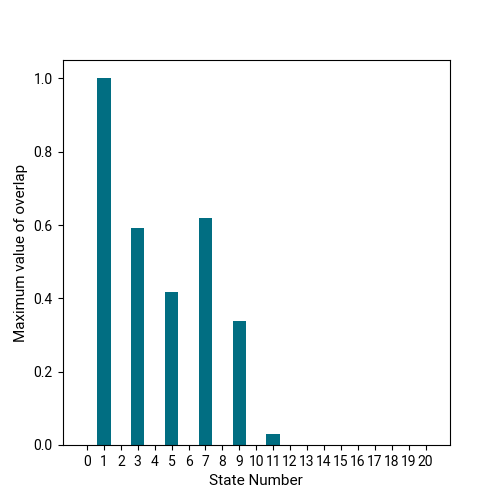

In [64]:
plt.close()
plt.figure(figsize = (5, 5))
state_label = np.array([str(i) for i in range(2*N+1)])
print(state_label.size)


plt.bar(state_label, overlap_maximas)
plt.xlabel("State Number")
plt.ylabel("Maximum value of overlap")
plt.show()

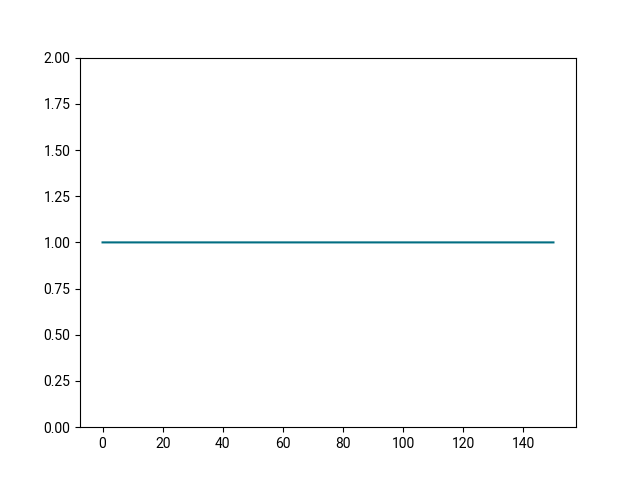

In [70]:
total_overlap = np.zeros(Points)
for key in overlaps_dictionary:
    total_overlap += overlaps_dictionary[key]
plt.close()
plt.plot(tlist, total_overlap)
plt.ylim(0, 2)
plt.show()

In [10]:
# T2 controls the width of the pulse
# Scan T2 from 25 to 150
# P0 controls the depth of the pulse
# Scan P0 from 0.01 to 0.99

ratio = 70
Ec = 0.25
Ej = Ec*ratio
N = 10 # number of levels in charge basis
ng = 0.5

T_max = 200
T1 = 50
R0 = 5 * np.pi

H_c = Hc(Ec=Ec, N=N, ng = ng)
H_j = Hj(Ej=Ej, N=N, ng=ng)

H_tot = hamiltonian(Ec, Ej, N, ng)


Points=10000
tlist = np.linspace(0, T_max, Points)
H_tot_tdep = [H_c, [H_j, Hd_coeff]]
evals, ekets = H_tot.eigenstates()
psi0 = (1/np.sqrt(2))*(ekets[0] + ekets[1])

P0_arr_size = 50
T2_arr_size = 50

P0_arr = np.linspace(0.94, 0.99, P0_arr_size)
T2_arr = np.linspace(25, 150, T2_arr_size)

final_probability_dict = {f"{state_n}":np.empty((P0_arr_size, T2_arr_size)) for state_n in range(2*N+1)}


for _ip, P0 in tqdm(enumerate(P0_arr)):
    for _it, T2 in tqdm(enumerate(T2_arr)):
        se_out = qt.sesolve(H_tot_tdep, psi0, tlist, args={'P0':P0, 'R0':R0, 'T1':T1, 'T2':T2}, progress_bar=None)
        for state_n in range(2*N+1):
            final_probability_dict[str(state_n)][_ip][_it] = np.abs(ekets[state_n].dag().overlap(se_out.states[-1]))**2
        
    
final_probability_dict

0it [00:00, ?it/s]

40it [06:48, 10.21s/it]
40it [04:42,  7.05s/it]
40it [02:55,  4.39s/it]
40it [04:16,  6.41s/it]
40it [15:07, 22.68s/it]
40it [02:28,  3.72s/it]
40it [02:24,  3.61s/it]
40it [02:24,  3.62s/it]
40it [02:24,  3.62s/it]
40it [03:24,  5.11s/it]
10it [46:56, 281.64s/it]


{'0': array([[2.53617641e-24, 1.15708261e-24, 2.21355543e-24, 2.34199809e-24,
         2.58858914e-25, 2.57235177e-24, 5.52393923e-25, 1.16298339e-24,
         1.58737405e-24, 3.54909386e-25, 1.67223793e-24, 7.35704168e-25,
         8.52350640e-25, 1.30734033e-24, 1.30156238e-24, 8.27729449e-25,
         1.89644509e-24, 2.61994229e-25, 2.22320441e-24, 3.23909058e-25,
         1.39986194e-24, 1.09977718e-24, 6.08023150e-25, 2.53859884e-24,
         5.63637485e-26, 2.80430136e-24, 3.76116067e-25, 1.68481923e-24,
         1.05681413e-24, 8.68439722e-25, 8.16182998e-25, 1.87765811e-24,
         2.16828722e-25, 1.90667670e-24, 9.10234828e-25, 7.49840964e-25,
         2.74172751e-24, 5.76670512e-26, 3.02174277e-24, 1.20885488e-24],
        [4.04453277e-25, 3.97301089e-24, 2.48002384e-25, 2.27711028e-24,
         2.14567825e-24, 1.42281102e-25, 1.95848698e-24, 1.28750504e-24,
         4.10756357e-25, 1.76649948e-24, 7.44588126e-25, 1.07864931e-24,
         6.78925716e-25, 2.00065282e-24, 1.63

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])
[[3.16709451e-01 2.18045081e-01 1.03153521e-01 2.43107452e-02
  1.86934677e-02 9.18470229e-02 2.14934842e-01 3.37202613e-01
  4.07759445e-01 3.97286564e-01 3.10228122e-01 1.82657794e-01
  6.68617105e-02 9.22896529e-03 3.06755306e-02 1.18029750e-01
  2.30118783e-01 3.16063970e-01 3.37567833e-01 2.85479724e-01
  1.83507204e-01 7.77567578e-02 1.68816720e-02 3.07915786e-02
  1.17094682e-01 2.41663600e-01 3.53209319e-01 4.05256309e-01
  3.76090871e-01 2.77859528e-01 1.51264624e-01 4.82687206e-02
  9.86759405e-03 4.86426628e-02 1.43717317e-01 2.50444127e-01
  3.20314560e-01 3.22180229e-01 2.55662295e-01 1.51024439e-01]
 [3.55876891e-01 2.23359887e-01 8.30798799e-02 7.06756183e-03
  4.19217660e-02 1.85464291e-01 3.85061514e-01 5.59379262e-01
  6.34096469e-01 5.75733192e-01 4.07998033e-01 2.03268483e-01
  5.22626014e-02 2.46930053e-02 1.37508754e-01 3.45505928e-01
  5

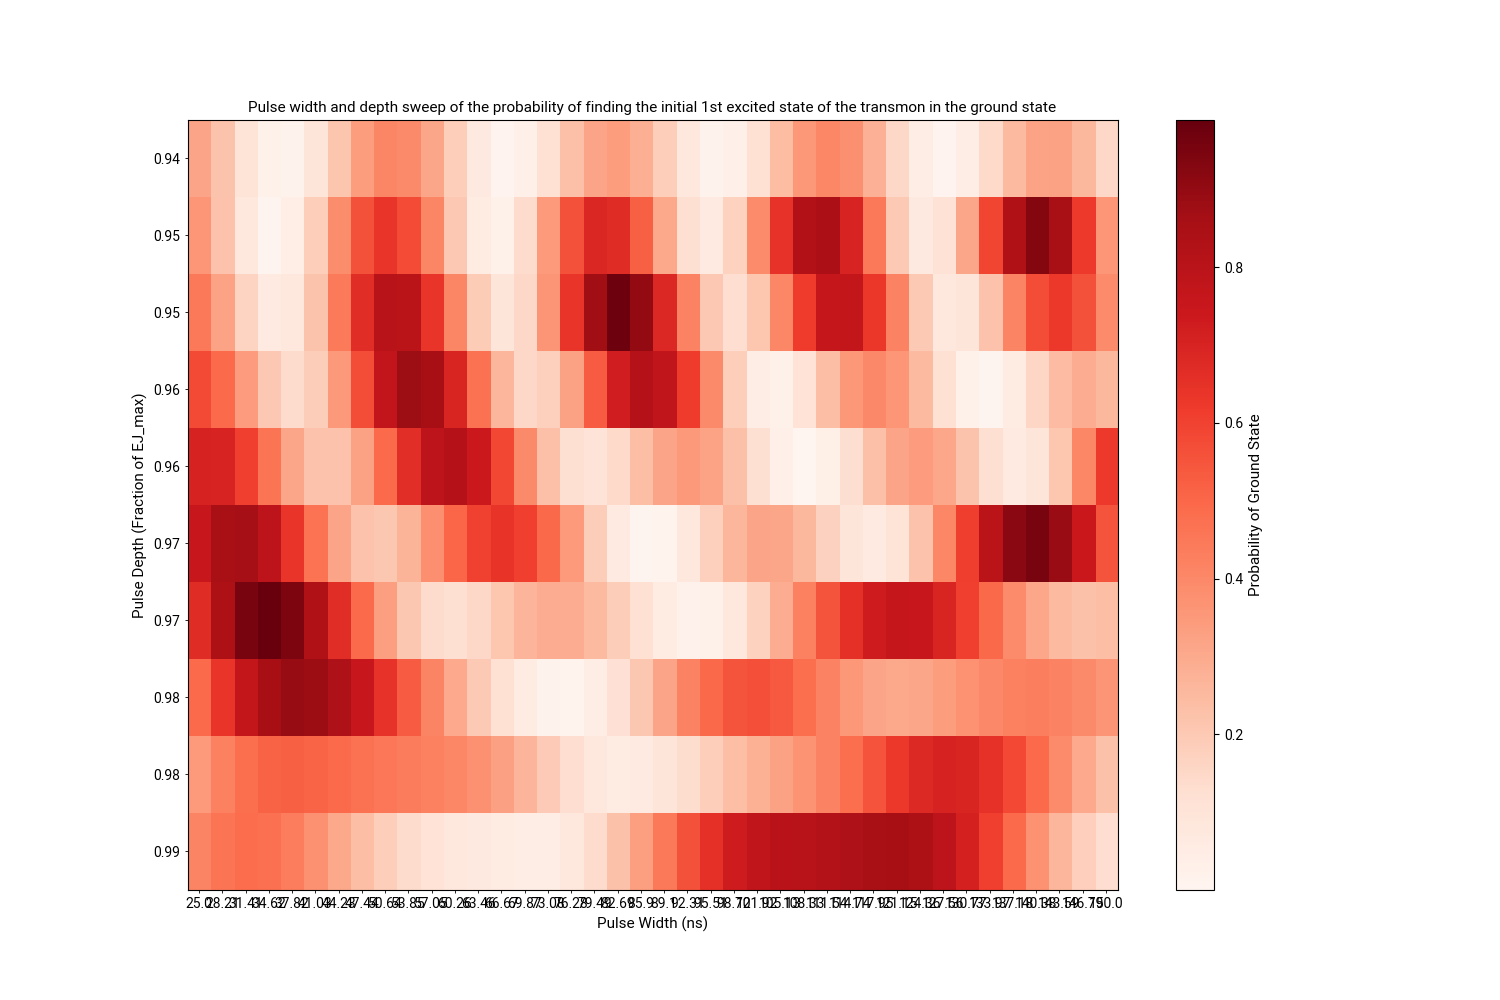

In [12]:
import matplotlib.ticker as ticker
print(final_probability_dict.keys())
state_0_prob_map = final_probability_dict["1"]
print(state_0_prob_map)

plt.close()
fig, ax =  plt.subplots(1, figsize=(15, 10))
img = ax.imshow(state_0_prob_map, cmap = 'Reds', extent = [T2_arr[0], T2_arr[-1], P0_arr[-1], P0_arr[0]], aspect = 'auto')
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator((np.linspace(T2_arr[0], T2_arr[-1], T2_arr_size+1)[1:] + np.linspace(T2_arr[0], T2_arr[-1], T2_arr_size+1)[:-1])/2))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(np.round(T2_arr, 2)))

ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_locator(ticker.FixedLocator((np.linspace(P0_arr[0], P0_arr[-1], P0_arr_size+1)[1:] + np.linspace(P0_arr[0], P0_arr[-1], P0_arr_size+1)[:-1])/2))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(np.round(P0_arr, 2)))

ax.set_xlabel("Pulse Width (ns)")
ax.set_ylabel("Pulse Depth (Fraction of EJ_max)")
ax.set_title("Pulse width and depth sweep of the probability of finding the initial 1st excited state of the transmon in the ground state")

fig.colorbar(img, ax=ax, label="Probability of Ground State")


plt.show()